In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

In [53]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("train shape:", train.shape, "test.shape:", test.shape)

train shape: (200000, 202) test.shape: (200000, 201)


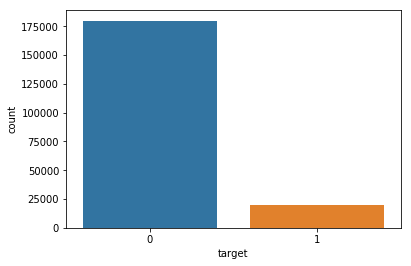

In [54]:
sns.countplot(train['target'])

In [55]:
total1 = train["target"].value_counts()[1]
print("There are {} target values with 1, is about {}% of total data".format(total1, 100 * total1/train.shape[0]))

There are 20098 target values with 1, is about 10.049% of total data


In [56]:
train0 = train.loc[train['target'] == 0]
train1 = train.loc[train['target'] == 1]
print(train0.shape, train1.shape)
splitNum = 2
t0PerSplit = train0.shape[0] // splitNum
print(t0PerSplit)
splits = []
for i in range(splitNum-1):
    splits.append(pd.concat([train0[i*t0PerSplit:(i+1)*t0PerSplit], train1]).sample(frac=1))
    print(splits[i].shape)
splits.append(pd.concat([train0[(splitNum-1)*t0PerSplit:], train1]).sample(frac=1))
print(splits[splitNum-1].shape)
splits[splitNum-1].iloc[:,1].values[:100]

(179902, 202) (20098, 202)
89951
(110049, 202)
(110049, 202)


array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
features = train.columns.values[2:202]
scaler = StandardScaler()
x_test = scaler.fit_transform(test[features])

In [58]:
X_test = x_test.reshape(200000,20,10,1)
predictions = np.zeros(len(X_test)) 
print(X_test.shape, predictions.shape)
for split_ in range(splitNum):
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)
    #train_s = splits[split_][features]
    train_s =  scaler.transform(splits[split_][features])
    target_s = splits[split_]["target"]
    print(train_s.shape, target_s.shape)
    prediction = np.zeros(len(test))
    oof = np.zeros(len(train_s))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_s, target_s)):
        X_train, y_train = train_s[trn_idx], target_s.iloc[trn_idx]
        X_train = X_train.reshape(trn_idx.shape[0], 20, 10, 1)
        X_valid, y_valid = train_s[val_idx], target_s.iloc[val_idx]
        X_valid = X_valid.reshape(val_idx.shape[0], 20, 10, 1)
        print("Split:", split_,  "Fold:",fold_, trn_idx.shape, val_idx.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
        #create model
        model = Sequential()
        #add model layers
        model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(20,10,1)))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        #compile model using accuracy to measure model performance
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        #train the model
        model.fit(X_train, y_train, batch_size=100, validation_data=(X_valid, y_valid), epochs=10)
    
        y_pred = model.predict_classes(X_valid)
        oof = model.predict_classes(X_valid)
        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
        # Accuracy: Overall, how often is the classifier correct?  (tp+tn) / (tn+fp+fn+tp)
        # Precision score, When it predicts yes, how often is it correct?  tp/(fp + tp)
        # Specificity, True Negative Rate: When it's actually no, how often does it predict no? tn/(tn+fp)
        # Recall score, or Sensitivity, True positive rate, When it's actually yes, how often does it predict yes? tp/(fn+tp)
    
        print("precision_score:", tp/(fp + tp), "specificity_score:", tn/(tn+fp), "recall_score:", tp/(fn+tp))
        # F1 score
        print("f1_score", f1_score(y_valid,y_pred))
        print("CV score: {:<8.5f}".format(roc_auc_score(y_valid, oof)))
        # Cohen's kappa score
        #cohen_kappa_score(y_valid, y_pred)
    
        prediction += model.predict_proba(X_test)[:,0] / folds.n_splits 
        #print("CV score: {:<8.5f}".format(roc_auc_score(target_s, oof)))
    predictions += prediction / splitNum   

(200000, 20, 10, 1) (200000,)
(110049, 200) (110049,)
Split: 0 Fold: 0 (99043,) (11006,) (99043, 20, 10, 1) (99043,) (11006, 20, 10, 1) (11006,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_151 (Conv2D)          (None, 18, 8, 64)         640       
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 16, 6, 32)         18464     
_________________________________________________________________
flatten_76 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 3073      
Total params: 22,177
Trainable params: 22,177
Non-trainable params: 0
_________________________________________________________________
Train on 99043 samples, validate on 11006 samples
Epoch 1/10
99043/99043 [==============================] - 16s 164us/step - 

Train on 99044 samples, validate on 11005 samples
Epoch 1/10
99044/99044 [==============================] - 17s 170us/step - loss: 0.3659 - acc: 0.8467 - val_loss: 0.3427 - val_acc: 0.8550
Epoch 2/10
99044/99044 [==============================] - 7s 74us/step - loss: 0.3305 - acc: 0.8618 - val_loss: 0.3300 - val_acc: 0.8626
Epoch 3/10
99044/99044 [==============================] - 7s 74us/step - loss: 0.3077 - acc: 0.8723 - val_loss: 0.3092 - val_acc: 0.8741
Epoch 4/10
99044/99044 [==============================] - 7s 73us/step - loss: 0.2963 - acc: 0.8779 - val_loss: 0.3071 - val_acc: 0.8725
Epoch 5/10
99044/99044 [==============================] - 7s 73us/step - loss: 0.2923 - acc: 0.8797 - val_loss: 0.3059 - val_acc: 0.8726
Epoch 6/10
99044/99044 [==============================] - 7s 73us/step - loss: 0.2893 - acc: 0.8809 - val_loss: 0.3066 - val_acc: 0.8712
Epoch 7/10
99044/99044 [==============================] - 7s 73us/step - loss: 0.2844 - acc: 0.8831 - val_loss: 0.3088 - val_a

99044/99044 [==============================] - 7s 74us/step - loss: 0.2934 - acc: 0.8792 - val_loss: 0.2851 - val_acc: 0.8818
Epoch 6/10
99044/99044 [==============================] - 7s 74us/step - loss: 0.2887 - acc: 0.8812 - val_loss: 0.2907 - val_acc: 0.8811
Epoch 7/10
99044/99044 [==============================] - 7s 74us/step - loss: 0.2849 - acc: 0.8832 - val_loss: 0.2882 - val_acc: 0.8812
Epoch 8/10
99044/99044 [==============================] - 7s 74us/step - loss: 0.2817 - acc: 0.8841 - val_loss: 0.2909 - val_acc: 0.8811
Epoch 9/10
99044/99044 [==============================] - 7s 74us/step - loss: 0.2778 - acc: 0.8866 - val_loss: 0.2909 - val_acc: 0.8828
Epoch 10/10
99044/99044 [==============================] - 7s 73us/step - loss: 0.2738 - acc: 0.8872 - val_loss: 0.3018 - val_acc: 0.8780
precision_score: 0.6878873239436619 specificity_score: 0.9384102279043913 recall_score: 0.6074626865671642
f1_score 0.6451783355350066
CV score: 0.77294 
Split: 0 Fold: 7 (99044,) (11005,)

99045/99045 [==============================] - 7s 74us/step - loss: 0.2779 - acc: 0.8861 - val_loss: 0.3121 - val_acc: 0.8744
Epoch 10/10
99045/99045 [==============================] - 7s 74us/step - loss: 0.2740 - acc: 0.8874 - val_loss: 0.3280 - val_acc: 0.8687
precision_score: 0.7831325301204819 specificity_score: 0.9759866592551417 recall_score: 0.38825286212045795
f1_score 0.519134775374376
CV score: 0.68212 
(110049, 200) (110049,)
Split: 1 Fold: 0 (99043,) (11006,) (99043, 20, 10, 1) (99043,) (11006, 20, 10, 1) (11006,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_171 (Conv2D)          (None, 18, 8, 64)         640       
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 16, 6, 32)         18464     
_________________________________________________________________
flatten_86 (Flatten)         (None, 3072)              0         
_____

Train on 99044 samples, validate on 11005 samples
Epoch 1/10
99044/99044 [==============================] - 19s 188us/step - loss: 0.3677 - acc: 0.8462 - val_loss: 0.3314 - val_acc: 0.8628
Epoch 2/10
99044/99044 [==============================] - 7s 75us/step - loss: 0.3290 - acc: 0.8636 - val_loss: 0.3163 - val_acc: 0.8691
Epoch 3/10
99044/99044 [==============================] - 7s 75us/step - loss: 0.3078 - acc: 0.8726 - val_loss: 0.2963 - val_acc: 0.8761
Epoch 4/10
99044/99044 [==============================] - 7s 75us/step - loss: 0.2999 - acc: 0.8760 - val_loss: 0.2996 - val_acc: 0.8763
Epoch 5/10
99044/99044 [==============================] - 7s 75us/step - loss: 0.2969 - acc: 0.8774 - val_loss: 0.2980 - val_acc: 0.8766
Epoch 6/10
99044/99044 [==============================] - 7s 75us/step - loss: 0.2931 - acc: 0.8788 - val_loss: 0.2966 - val_acc: 0.8765
Epoch 7/10
99044/99044 [==============================] - 7s 75us/step - loss: 0.2888 - acc: 0.8801 - val_loss: 0.2986 - val_a

99044/99044 [==============================] - 8s 77us/step - loss: 0.2938 - acc: 0.8784 - val_loss: 0.3037 - val_acc: 0.8764
Epoch 6/10
99044/99044 [==============================] - 8s 77us/step - loss: 0.2899 - acc: 0.8794 - val_loss: 0.2991 - val_acc: 0.8801
Epoch 7/10
99044/99044 [==============================] - 8s 77us/step - loss: 0.2871 - acc: 0.8813 - val_loss: 0.3284 - val_acc: 0.8680
Epoch 8/10
99044/99044 [==============================] - 8s 77us/step - loss: 0.2816 - acc: 0.8834 - val_loss: 0.2994 - val_acc: 0.8788
Epoch 9/10
99044/99044 [==============================] - 8s 77us/step - loss: 0.2791 - acc: 0.8858 - val_loss: 0.3026 - val_acc: 0.8783
Epoch 10/10
99044/99044 [==============================] - 8s 77us/step - loss: 0.2754 - acc: 0.8862 - val_loss: 0.3079 - val_acc: 0.8733
precision_score: 0.7730496453900709 specificity_score: 0.9715397443023902 recall_score: 0.4338308457711443
f1_score 0.5557680050987891
CV score: 0.70269 
Split: 1 Fold: 7 (99044,) (11005,)

99045/99045 [==============================] - 8s 77us/step - loss: 0.2784 - acc: 0.8858 - val_loss: 0.3136 - val_acc: 0.8696
Epoch 10/10
99045/99045 [==============================] - 8s 78us/step - loss: 0.2746 - acc: 0.8867 - val_loss: 0.3166 - val_acc: 0.8679
precision_score: 0.6871207012811867 specificity_score: 0.9484157865480822 recall_score: 0.5072175211548033
f1_score 0.5836197021764031
CV score: 0.72782 


In [59]:
print(predictions.shape)
predictions[:50]

(200000,)


array([0.4042907 , 0.29332411, 0.31074656, 0.2408354 , 0.05448758,
       0.00310434, 0.00642114, 0.33797616, 0.00447174, 0.01127124,
       0.23629842, 0.08005835, 0.05530127, 0.04474903, 0.00727543,
       0.04885159, 0.52325466, 0.03196429, 0.29091611, 0.01647526,
       0.38375801, 0.07122458, 0.01096452, 0.04401419, 0.02790601,
       0.1172291 , 0.13600709, 0.01327486, 0.30555904, 0.18246234,
       0.08867435, 0.11209405, 0.48169972, 0.6506532 , 0.01415599,
       0.03971917, 0.01305653, 0.02453808, 0.01131573, 0.01092332,
       0.02952132, 0.00896007, 0.01361847, 0.00662359, 0.03840213,
       0.05469622, 0.0119746 , 0.07994453, 0.01907935, 0.04105049])

In [60]:
sub = pd.DataFrame() 
sub["ID_code"] = test["ID_code"] 
sub["target"] = predictions
sub.to_csv("submission-cnn-ksplit.csv", index=False)